In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os 
import cv2
import random
from sklearn.utils import class_weight
import tensorflow as tf

# Data Flow

In [2]:
import requests
import json

base_url = 'https://api.figshare.com/v2'

article_id = '1512427'

response = requests.get(f'{base_url}/articles/{article_id}')
article = json.loads(response.text)
data= []
for i in range(4):
  file_url = article['files'][i]['download_url']
  print(file_url)
  response = requests.get(file_url)
  
  data.append(response.content)

with open('brain_tumor_dataset.zip', 'wb') as f:
    f.write(data[0])
with open('brain_tumor_dataset1.zip', 'wb') as f:
    f.write(data[1])  
with open('brain_tumor_dataset2.zip', 'wb') as f:
    f.write(data[2])
with open('brain_tumor_dataset3.zip', 'wb') as f:
    f.write(data[3])          
    

https://ndownloader.figshare.com/files/3381290
https://ndownloader.figshare.com/files/3381293
https://ndownloader.figshare.com/files/3381296
https://ndownloader.figshare.com/files/3381302


In [3]:
import zipfile
import h5py
from io import BytesIO
images_list = []
labels_list = []
 
with zipfile.ZipFile('brain_tumor_dataset.zip', 'r') as zip_file:
    for file_name in zip_file.namelist():
        if file_name.endswith('.mat'):
            with h5py.File(BytesIO(zip_file.read(file_name)), 'r') as f:
                image_data = f['cjdata']['image']
                images_list.append(np.array(image_data)); 

                label_data = f['cjdata']['label']
                labels_list.append(np.array(label_data));
 
with zipfile.ZipFile('brain_tumor_dataset1.zip', 'r') as zip_file:
    for file_name in zip_file.namelist():
        if file_name.endswith('.mat'):
            with h5py.File(BytesIO(zip_file.read(file_name)), 'r') as f:
                image_data = f['cjdata']['image']
                images_list.append(np.array(image_data)); 
                
                label_data = f['cjdata']['label']
                labels_list.append(np.array(label_data));
                
with zipfile.ZipFile('brain_tumor_dataset2.zip', 'r') as zip_file:
    for file_name in zip_file.namelist():
        if file_name.endswith('.mat'):
            with h5py.File(BytesIO(zip_file.read(file_name)), 'r') as f:
                image_data = f['cjdata']['image']
                images_list.append(np.array(image_data)); 
                
                label_data = f['cjdata']['label']
                labels_list.append(np.array(label_data));
                
with zipfile.ZipFile('brain_tumor_dataset3.zip', 'r') as zip_file:
    for file_name in zip_file.namelist():
        if file_name.endswith('.mat'):
            with h5py.File(BytesIO(zip_file.read(file_name)), 'r') as f:
                image_data = f['cjdata']['image']
                images_list.append(np.array(image_data)); 
                
                label_data = f['cjdata']['label']
                labels_list.append(np.array(label_data)); 

In [4]:
max_value = max([images_list[i].max() for i in range(len(images_list))])
max_value

12728

In [5]:
min_value = min([images_list[i].min() for i in range(len(images_list))])
min_value

0

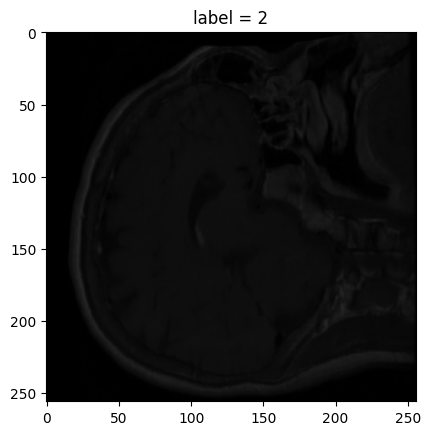

In [14]:
plt.imshow(X_train[122])
plt.title("label = "+str(y_train[122])
plt.show()

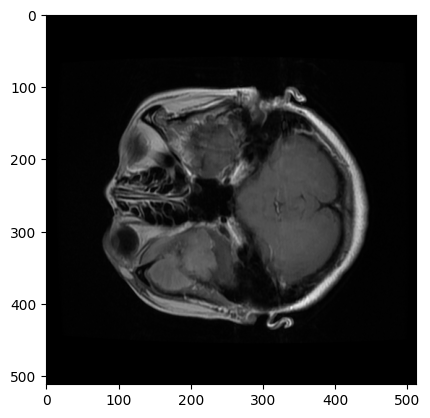

In [6]:
plt.imshow(images_list[32],cmap = 'gray')
plt.show()

In [7]:
from skimage.color import gray2rgb

resized_images_list = []
for image in images_list:
    image = image.astype(np.float32)/max_value
    resized_image = cv2.resize((image), (256, 256))
    resized_image = gray2rgb(resized_image)
    resized_images_list.append(resized_image)
images = np.array(resized_images_list)

In [8]:
del resized_images_list
del images_list
import gc
gc.collect()

3316

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, np.array(labels_list), test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
y_train.shape, y_val.shape, y_test.shape

((1838, 1, 1), (460, 1, 1), (766, 1, 1))

In [11]:
from keras.utils import to_categorical
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

y_train = to_categorical(y_train.squeeze())
y_val = to_categorical(y_val.squeeze())
y_test = to_categorical(y_test.squeeze())

In [12]:
X_train.shape, y_train.shape

((1838, 256, 256, 3), (1838, 3))

In [13]:
del images
import gc
gc.collect()

0

# Model

In [20]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, LeakyReLU, Flatten
from tensorflow import keras 

IMAGE_SIZE  = (256,256,3)

model = InceptionResNetV2(include_top = False,
                        weights = 'imagenet',
                        input_shape = IMAGE_SIZE)

for layer in model.layers:
  layer.trainable = False

x = model.output
x = Flatten()(x)
x = Dense(2048)(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Dropout(0.4)(x)
x = Dense(2048)(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Dropout(0.4)(x)
x = Dense(1024)(x)
x = LeakyReLU(alpha = 0.2)(x)
x = Dropout(0.4)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs = model.input, outputs = predictions)
model.summary();

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 127, 127, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                           

In [16]:
import pandas as pd
import seaborn as sns

def score_table(model):
    score = model.evaluate(X_test, y_test, verbose='0')
    df = pd.DataFrame({'Test Loss': [score[0]], 'Test Accuracy': [score[1]]})
    print('\n\n', df, '\n\n')
    
def plot_accuracy(histroy):
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()
    plt.plot(history.history['val_accuracy'])
    plt.title('Validation Accuracy')
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['validation'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.title('Train Loss')
    plt.ylabel('Train Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()
    plt.plot(history.history['val_loss'])
    plt.title('Validation Loss')
    plt.ylabel('Validation Loss')
    plt.xlabel('Epoch')
    plt.legend(['validation'], loc='upper left')
    plt.show()   



Epoch 1/5
58/58 [==============================] - 35s 371ms/step - loss: 33.2882 - accuracy: 0.6148 - precision_m: 0.6156 - f1_m: 0.6151 - val_loss: 7.1860 - val_accuracy: 0.6935 - val_precision_m: 0.7028 - val_f1_m: 0.7028
Epoch 2/5
58/58 [==============================] - 19s 333ms/step - loss: 6.3379 - accuracy: 0.7421 - precision_m: 0.7425 - f1_m: 0.7425 - val_loss: 4.5276 - val_accuracy: 0.7761 - val_precision_m: 0.7819 - val_f1_m: 0.7819
Epoch 3/5
58/58 [==============================] - 17s 295ms/step - loss: 3.8438 - accuracy: 0.8123 - precision_m: 0.8120 - f1_m: 0.8117 - val_loss: 3.8232 - val_accuracy: 0.7717 - val_precision_m: 0.7797 - val_f1_m: 0.7787
Epoch 4/5
58/58 [==============================] - 19s 328ms/step - loss: 2.4732 - accuracy: 0.8406 - precision_m: 0.8419 - f1_m: 0.8417 - val_loss: 1.0013 - val_accuracy: 0.8783 - val_precision_m: 0.8833 - val_f1_m: 0.8833
Epoch 5/5
58/58 [==============================] - 19s 331ms/step - loss: 1.2179 - accuracy: 0.8781 - p

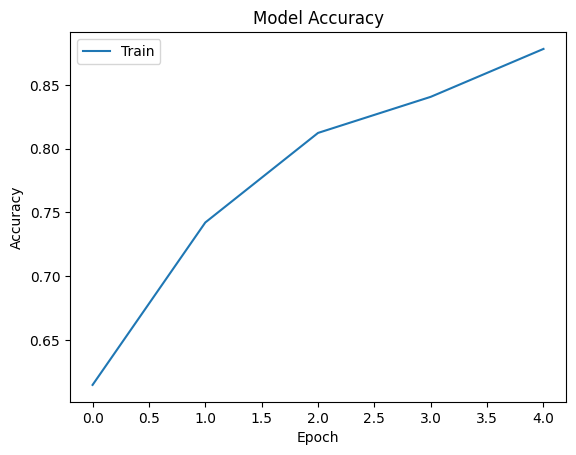

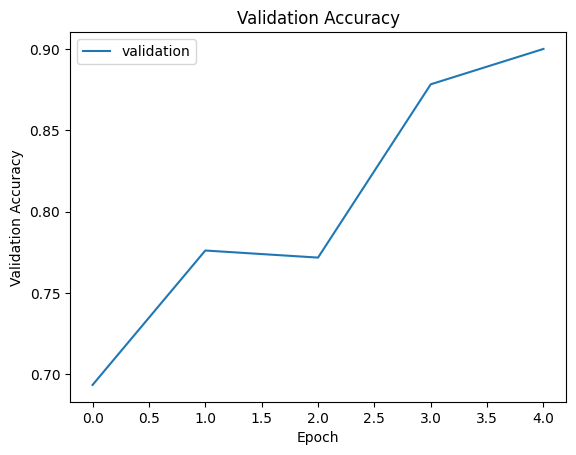

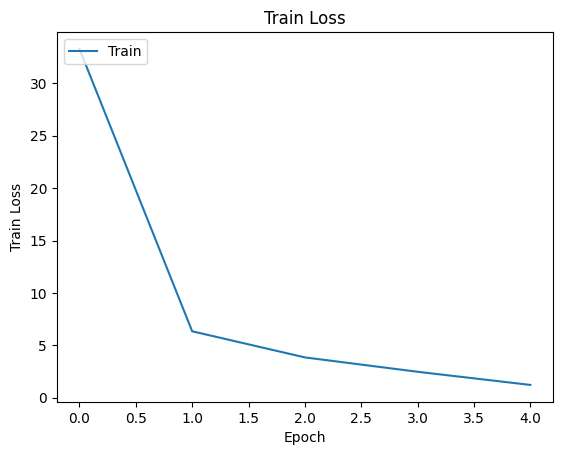

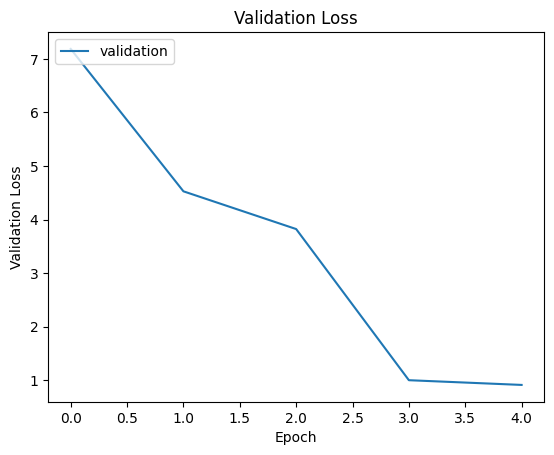

In [21]:
batch_size = 32 
nb_epoch = 5
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision_m, f1_m])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=nb_epoch) 

score_table(model)

plot_accuracy(history)

In [22]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)

24/24 [==============================] - 8s 224ms/step


In [25]:
y_test_c =np.array([np.argmax(y) for y in y_test])
y_pred_c = np.array([np.argmax(1) for y in y_pred])

In [30]:
print(classification_report(y_test_c,y_pred_c,target_names=['Meningioma', 'Glioma' , 'Pituitary']))

              precision    recall  f1-score   support

  Meningioma       0.84      0.79      0.81       193
      Glioma       0.95      0.91      0.93       343
   Pituitary       0.88      0.97      0.92       230

    accuracy                           0.90       766
   macro avg       0.89      0.89      0.89       766
weighted avg       0.90      0.90      0.90       766



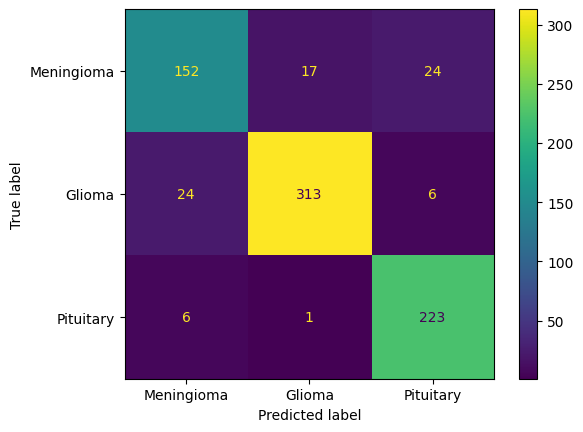

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


class_names=['Meningioma', 'Glioma' , 'Pituitary']


from sklearn.metrics import multilabel_confusion_matrix
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_test_c, y_pred_c)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names)

cm_display.plot()
plt.show()